In [1]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

# Customer Call Analysis

## 1. Loading the Datasets

In this step, we are loading the CSV files that contain various data related to customer calls into pandas DataFrames.

In [2]:
calls = pd.read_csv('/kaggle/input/skyhack/calls.csv')
customers = pd.read_csv('/kaggle/input/skyhack/customers.csv')
reason = pd.read_csv('/kaggle/input/skyhack/reason.csv')
sentiment_statistics = pd.read_csv('/kaggle/input/skyhack/sentiment_statistics.csv')
test = pd.read_csv('/kaggle/input/skyhack/test.csv')

In [13]:
test.head()

,call_id
0,7732610078
1,2400299738
2,6533095063
3,7774450920
4,9214147168


## WORD CLOUD

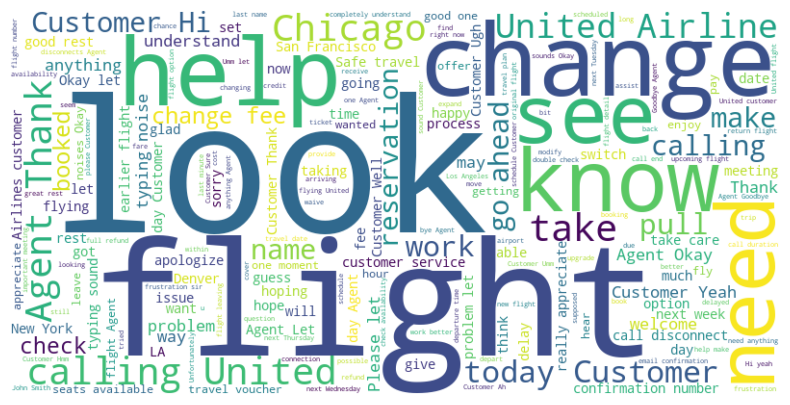

In [15]:
# Step 1: Add a Column for Handling Time in `calls`
calls['call_start_datetime'] = pd.to_datetime(calls['call_start_datetime'])
calls['call_end_datetime'] = pd.to_datetime(calls['call_end_datetime'])
calls['agent_assigned_datetime'] = pd.to_datetime(calls['agent_assigned_datetime'])
calls['handle_time'] = (calls['call_end_datetime'] - calls['agent_assigned_datetime']).dt.total_seconds() / 60  # in minutes

# Step 2: Combine with `reason` and `sentiment_statistics` using `call_id`
combined_df = calls.merge(reason, on='call_id').merge(sentiment_statistics, on='call_id')

# Step 3: Convert `call_transcript` to Numerical Feature using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)  # Adjust max_features as needed
tfidf_matrix = vectorizer.fit_transform(combined_df['call_transcript'].fillna(''))

# Create a DataFrame from the TF-IDF features
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Merge TF-IDF features with the original DataFrame
combined_df = pd.concat([combined_df.reset_index(drop=True), tfidf_df], axis=1)

# Step 3.1: Word Cloud for `call_transcript`
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(combined_df['call_transcript'].fillna('')))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

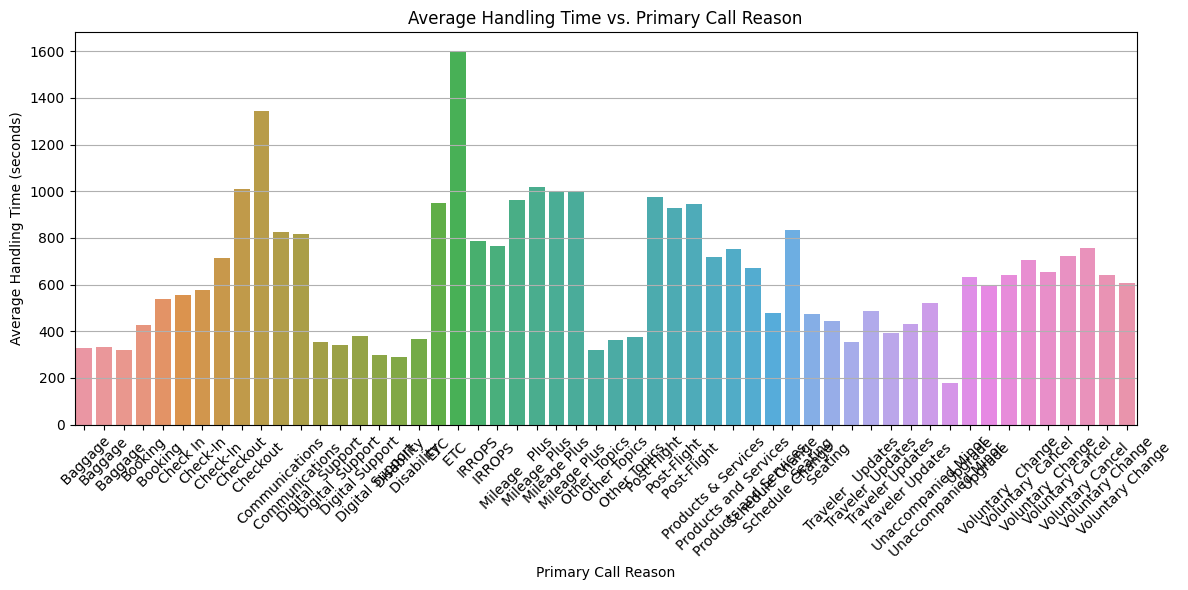

In [15]:
calls['call_start_datetime'] = pd.to_datetime(calls['call_start_datetime'])
calls['agent_assigned_datetime'] = pd.to_datetime(calls['agent_assigned_datetime'])
calls['call_end_datetime'] = pd.to_datetime(calls['call_end_datetime'])

# Calculating handle_time and answer_time
calls['handle_time'] = calls['call_end_datetime'] - calls['agent_assigned_datetime']
calls['answer_time'] = calls['agent_assigned_datetime'] - calls['call_start_datetime']

merged_df = calls.merge(reason, on='call_id', how='inner')

# Step 1: Group by 'primary_call_reason' and calculate the average handling time
average_handling_time = merged_df.groupby('primary_call_reason')['handle_time'].mean().reset_index()

# Step 2: Convert handling_time to total seconds for easier plotting
average_handling_time['handle_time_seconds'] = average_handling_time['handle_time'].dt.total_seconds()

# Step 3: Create a bar plot for average handling time vs. primary call reason
plt.figure(figsize=(12, 6))
sns.barplot(x='primary_call_reason', y='handle_time_seconds', data=average_handling_time)
plt.title('Average Handling Time vs. Primary Call Reason')
plt.xlabel('Primary Call Reason')
plt.ylabel('Average Handling Time (seconds)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Epoch 0, Loss: 449.30030584335327
Epoch 1, Loss: 375.339715719223
Epoch 2, Loss: 366.4416677951813
Epoch 3, Loss: 364.59226751327515
Epoch 4, Loss: 363.11634826660156
Epoch 5, Loss: 361.5216751098633
Epoch 6, Loss: 360.3569140434265
Epoch 7, Loss: 359.210168838501
Epoch 8, Loss: 357.9249129295349
Epoch 9, Loss: 356.41491651535034
Epoch 10, Loss: 355.00539994239807
Epoch 11, Loss: 353.83216643333435
Epoch 12, Loss: 352.3148121833801
Epoch 13, Loss: 350.8922629356384
Epoch 14, Loss: 349.3759808540344
Epoch 15, Loss: 348.2176468372345
Epoch 16, Loss: 346.439661026001
Epoch 17, Loss: 345.0893533229828
Epoch 18, Loss: 344.0479257106781
Epoch 19, Loss: 342.5701515674591
Epoch 20, Loss: 340.76860427856445
Epoch 21, Loss: 339.6283528804779
Epoch 22, Loss: 337.9480609893799
Epoch 23, Loss: 336.62131810188293
Epoch 24, Loss: 335.2306025028229
Epoch 25, Loss: 333.78228998184204
Epoch 26, Loss: 332.59520983695984
Epoch 27, Loss: 331.21105575561523
Epoch 28, Loss: 329.6696650981903
Epoch 29, Loss: 

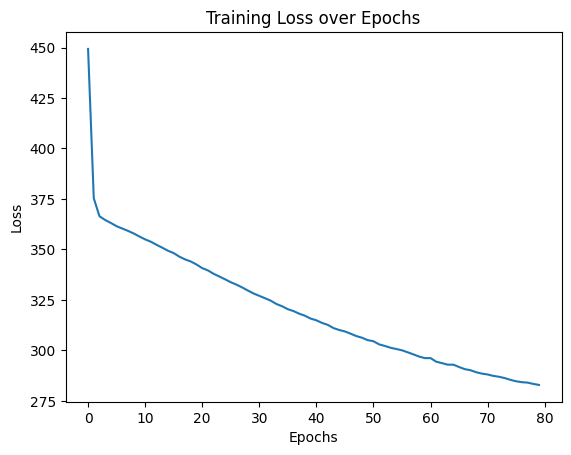

TypeError: linear(): argument 'input' (position 1) must be Tensor, not list

In [17]:
#%% Packages
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt


# Ensure call_id is unique in the reason table
reason = reason.drop_duplicates(subset=['call_id'])

#%% Extract Test Set Transcripts
# Extract call_ids from the test set
test_call_ids = test['call_id'].unique()

# Filter out test call_ids from the calls dataset
training_calls = calls[~calls['call_id'].isin(test_call_ids)]

# Get transcripts from the test set for evaluation later
test_transcripts = calls[calls['call_id'].isin(test_call_ids)]

#%% Merge Training Calls with Reason
# Merge training calls with reasons to get the target variable
merged_df = training_calls.merge(reason, on='call_id', how='inner')

#%% Get Class Values Based on Primary Call Reason
# Create a mapping for primary_call_reason to class values
unique_reasons = merged_df['primary_call_reason'].unique()
cat_id = {reason: idx for idx, reason in enumerate(unique_reasons)}

# Create target labels for training
merged_df['class'] = merged_df['primary_call_reason'].map(cat_id)

#%% Independent and Dependent Features
X = merged_df['call_transcript'].values
y = merged_df['class'].values

#%% One-Hot Encoding
vectorizer = CountVectorizer()
X_train_onehot = vectorizer.fit_transform(X)

# Prepare test transcripts for evaluation
test_transcripts_onehot = vectorizer.transform(test_transcripts['call_transcript'].values)

#%% Dataset Class
class CallData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X.toarray())
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    

train_ds = CallData(X=X_train_onehot, y=y)

# %% Dataloader
BATCH_SIZE = 512
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)

# %% Model
class CallReasonModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN=10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

#%% Model, Loss and Optimizer
model = CallReasonModel(NUM_FEATURES=X_train_onehot.shape[1], NUM_CLASSES=len(unique_reasons))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

# %% Model Training
NUM_EPOCHS = 80
train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())
        
        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e}, Loss: {curr_loss}")

# %% Plot Training Loss
sns.lineplot(x=list(range(len(train_losses))), y=train_losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# %% Model Evaluation on Test Set
with torch.no_grad():
    test_transcripts_ds = CallData(X=test_transcripts_onehot, y=np.zeros(test_transcripts_onehot.shape[0]))  # y is a placeholder
    test_loader_transcripts = DataLoader(dataset=test_transcripts_ds, batch_size=BATCH_SIZE, shuffle=False)

    for X_batch in test_loader_transcripts:
        test_preds_transcripts = model(X_batch)
        y_test_transcripts_pred = torch.argmax(test_preds_transcripts, dim=1)

# %% Convert predictions to original categories
predicted_reasons = [unique_reasons[i] for i in y_test_transcripts_pred]

# %% Result Output
test_transcripts['predicted_primary_call_reason'] = predicted_reasons
print(test_transcripts[['call_id', 'predicted_primary_call_reason']])

# %% Confusion Matrix for Evaluation
confusion_mat = confusion_matrix(y_test_transcripts_pred, np.zeros(test_transcripts_onehot.shape[0]))  # Placeholder y for confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt=".0f", cmap='Blues')
plt.title('Confusion Matrix for Test Transcripts')
plt.xlabel('Predicted Class')
plt.ylabel('True Class (not applicable)')
plt.show()


Epoch 0, Loss: 418.7765872478485


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


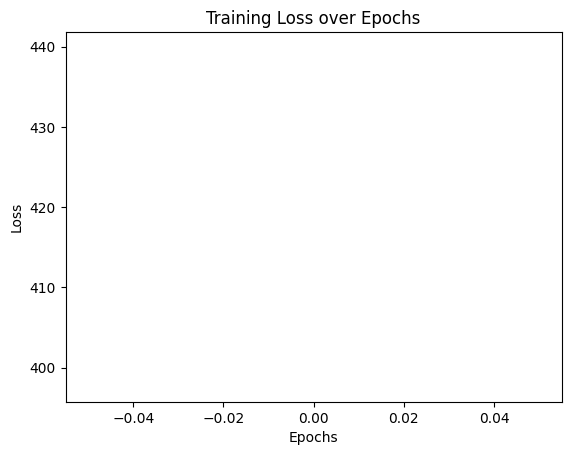

          call_id predicted_primary_call_reason
11     7732610078              Voluntary Change
33     2400299738                        IRROPS
48     6533095063                        IRROPS
56     7774450920                        IRROPS
57     9214147168                        IRROPS
...           ...                           ...
71713  5300201106                        IRROPS
71736   727694488                        IRROPS
71755   147487837                        IRROPS
71771  5330794838              Voluntary Change
71808  8332067080              Voluntary Change

[5157 rows x 2 columns]
True primary call reasons not found in the test transcripts.


/tmp/ipykernel_259/2765748768.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_transcripts['predicted_primary_call_reason'] = predicted_reasons


In [3]:
# %% Packages
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt


# Ensure call_id is unique in the reason table
reason = reason.drop_duplicates(subset=['call_id'])

# %% Extract Test Set Transcripts
# Extract call_ids from the test set
test_call_ids = test['call_id'].unique()

# Filter out test call_ids from the calls dataset
training_calls = calls[~calls['call_id'].isin(test_call_ids)]

# Get transcripts from the test set for evaluation later
test_transcripts = calls[calls['call_id'].isin(test_call_ids)]

# %% Merge Training Calls with Reason
# Merge training calls with reasons to get the target variable
merged_df = training_calls.merge(reason, on='call_id', how='inner')

# %% Get Class Values Based on Primary Call Reason
# Create a mapping for primary_call_reason to class values
unique_reasons = merged_df['primary_call_reason'].unique()
cat_id = {reason: idx for idx, reason in enumerate(unique_reasons)}

# Create target labels for training
merged_df['class'] = merged_df['primary_call_reason'].map(cat_id)

# %% Independent and Dependent Features
X = merged_df['call_transcript'].values
y = merged_df['class'].values

# %% One-Hot Encoding
vectorizer = CountVectorizer()
X_train_onehot = vectorizer.fit_transform(X)

# Prepare test transcripts for evaluation
test_transcripts_onehot = vectorizer.transform(test_transcripts['call_transcript'].values)

# %% Dataset Class
class CallData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X.toarray())
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    

train_ds = CallData(X=X_train_onehot, y=y)

# %% Dataloader
BATCH_SIZE = 512
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)

# %% Model
class CallReasonModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN=10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

# %% Model, Loss and Optimizer
model = CallReasonModel(NUM_FEATURES=X_train_onehot.shape[1], NUM_CLASSES=len(unique_reasons))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

# %% Model Training
NUM_EPOCHS = 1
train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())
        
        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e}, Loss: {curr_loss}")

# %% Plot Training Loss
sns.lineplot(x=list(range(len(train_losses))), y=train_losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# %% Model Evaluation on Test Set
with torch.no_grad():
    test_transcripts_ds = CallData(X=test_transcripts_onehot, y=np.zeros(test_transcripts_onehot.shape[0]))  # y is a placeholder
    test_loader_transcripts = DataLoader(dataset=test_transcripts_ds, batch_size=BATCH_SIZE, shuffle=False)

    y_test_transcripts_pred = []
    
    for X_batch, _ in test_loader_transcripts:
        test_preds_transcripts = model(X_batch)
        y_test_transcripts_pred_batch = torch.argmax(test_preds_transcripts, dim=1)
        y_test_transcripts_pred.extend(y_test_transcripts_pred_batch.numpy())

# %% Convert predictions to original categories
predicted_reasons = [unique_reasons[i] for i in y_test_transcripts_pred]

# %% Result Output
test_transcripts['predicted_primary_call_reason'] = predicted_reasons
print(test_transcripts[['call_id', 'predicted_primary_call_reason']])

# %% Confusion Matrix for Evaluation
# Assuming you have true labels for the test set in test_transcripts['true_primary_call_reason']
# You need to replace 'true_primary_call_reason' with the actual column name in your dataset that contains the true labels.
if 'true_primary_call_reason' in test_transcripts.columns:
    confusion_mat = confusion_matrix(test_transcripts['predicted_primary_call_reason'], test_transcripts['true_primary_call_reason'])
    sns.heatmap(confusion_mat, annot=True, fmt=".0f", cmap='Blues')
    plt.title('Confusion Matrix for Test Transcripts')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()
else:
    print("True primary call reasons not found in the test transcripts.")
